# Monet Paintings GAN

The "I'm Somethigng of a Painter Myself" Kaggle project is a project that ranks participants on their ability to best mimick the style of the popular aritst Claude Monet by using generative adversarial networks (GANs). The GAN created in this notebook will need to produce 7,000 - 10,000 Monet-style images. There are two sources of data for this competition. The first dataset is the true Monet paintings, which are available in both .jpg and .tfrec formats for usability. There is a secondary dataset that consists of pictures of various landscapes, cities, animals, etc. These are the pictures that will be transformed to Monet's style.

The submissions will be evaluated on the MiFID (Memorization-informed Fréchet Inception Distance), which is modified from Fréchet Inception Distance (FID) score and is commonly used to evaluate the ability of GANs. The lower the MiFID score the better.  

### Data

Specific information on the files are as follows:

* monet_jpg: 300 Monet paintings sized 256x256 in JPEG format
* monet_tfrec: 300 Monet paintings sized 256x256 in TFRecord forma
* photo_jpg: 7028 photos sized 256x256 in JPEG format
* photo_tfrec: 7028 photos sized 256x256 in TFRecord format

The submission format should be a images.zip package that conatins 7,000 - 10,000 images that are size 256 x 256.

### What are GANs

GANs are powerful neural network machine learning models that consist of a generator and a discriminator. The generator's task is to continuously create copies of the proposed output over time. The discriminator's role is to differentiate between which image is real and which one is generated. In the first attempt, the generator does a very poor job at creating an output that looks like the actual image, however, throughout many epochs where each step feedback is being generated from the discriminator, the generator's attempts get better and better until they very closely match the actual image.

The particuar type of GAN that will be demonstrated in this notebook is a CycleGAN that uses a special consistency loss to enable training without the need for multiple sets of the same images. Therefore, it can translate from one domain to another very easily. A CycleGAN model is a appropriate model to use in this type of style transfer task. 

## Imports

In [1]:
# general imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from kaggle_datasets import KaggleDatasets
import os
import PIL
import shutil
import cv2

# tensorflow specific
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2025-02-05 00:16:07.997429: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-05 00:16:07.997582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-05 00:16:08.126251: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Data Loading

To begin, I will get the file names and paths to enable the data to be read for both the Monet and photo .tfrec files.

In [2]:
# useing the Kaggle get_gcs_path function to access Google Cloud Storage files
gcs_path = KaggleDatasets().get_gcs_path()

# getting all the files that match the format with the gcs_path included
monet_filenames = tf.io.gfile.glob(f"{gcs_path}/monet_tfrec/*.tfrec")
photo_filenames = tf.io.gfile.glob(f"{gcs_path}/photo_tfrec/*tfrec")

# settign the image size to 256 x 256 pixels
image_size = [256, 256]

# Tensorflow variable that allows for dynamically decision around the number of threads to use for loading and processing
autotune = tf.data.experimental.AUTOTUNE

In [3]:
# defining a decode_image function that decodes our image to a 3D tensor with 3 color RGB channels
# and resizing/scaling the image so it is the correct output size
def decode_image(image):
    image = tf.image.decode_jpeg(image, channels = 3)
    return tf.image.resize(image, image_size) / 127.5 - 1

In [4]:
# loading the dataset with the load_dataset function and _parse_tfrecord sub function
# The sub function takes a single image and decodes, resizes it, and normalizes the values and returns the example, and then the entire dataset
def load_dataset(filenames, repeat = True, batch_size = 1):
    def _parse_tfrecord(tfrecord):
        feature_description = {"image": tf.io.FixedLenFeature([], tf.string)}
        example = tf.io.parse_single_example(tfrecord, feature_description)
        return decode_image(example['image'])
    
    dataset = tf.data.TFRecordDataset(filenames).map(_parse_tfrecord, num_parallel_calls = autotune)
    if repeat:
        dataset = dataset.repeat()
    return dataset.batch(batch_size)

In [5]:
# passing our monet and photo file names to the load_dataset function from above, we should be good to go
monet_ds = load_dataset(monet_filenames)
photo_ds = load_dataset(photo_filenames)

## EDA

As part of the EDA process, I will start by checking the number of images in both the Monet and photos and checking their shape. This ensures our load_dataset function worked properly and will not confuse our model later on. Then I will visualize a handful of images from both the Monet and photo folders. From there, I looked at a historgram of the pixel density for both the Monet and photo images. What was interesting was in the photos folder, there were quite a few images that had a very low density of pixels, meaning they might look fuzzy to begin with. On the flip side, the Monet photos had a bell shaped distribution which will help our model when they are passed along. 

Furthermore, I was able to graph the red, green, and blue channels for a handful of images. This was interesting to see how the composition of the photos changed the values in the specific color graph. Although there was not much application for this visualization, it was still interesting to graph.

Finally, I graphed some basic statistics around the number of pixels present in each photo. It was interesting to learn that both sets of photos had 0 pixel images. Removing the photos with 0 pixels is one area that could improve our models overall score.

In [6]:
# defining a new function to get the paths to get the number of images in each folder
def getImagePaths(path):
    image_names = []
    for dirname, _, filenames in os.walk(path):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            image_names.append(fullpath)
    return image_names


In [7]:
# calling the getImagePaths function
monet_images_path = getImagePaths('/kaggle/input/gan-getting-started/monet_jpg/')
photo_images_path = getImagePaths('/kaggle/input/gan-getting-started/photo_jpg/')

In [8]:
print(f'The number of Monet images is: {len(monet_images_path)}')
print(f'The number of photo images is: {len(photo_images_path)}')

The number of Monet images is: 300
The number of photo images is: 7038


In [9]:
# creating a function to get the particular images shape, they look good and no adjustments need to be made
def getShape(images_paths):
    shape = cv2.imread(images_paths[0]).shape
    for image_path in images_paths:
        image_shape = cv2.imread(image_path).shape
        if (image_shape != shape):
            return "Different image shape"
        else:
            return 'same image shape, the shape is: ' + str(shape)
        
print(f'The monet images have the ' + getShape(monet_images_path))
print(f'The photo images have the ' + getShape(monet_images_path))

The monet images have the same image shape, the shape is: (256, 256, 3)
The photo images have the same image shape, the shape is: (256, 256, 3)


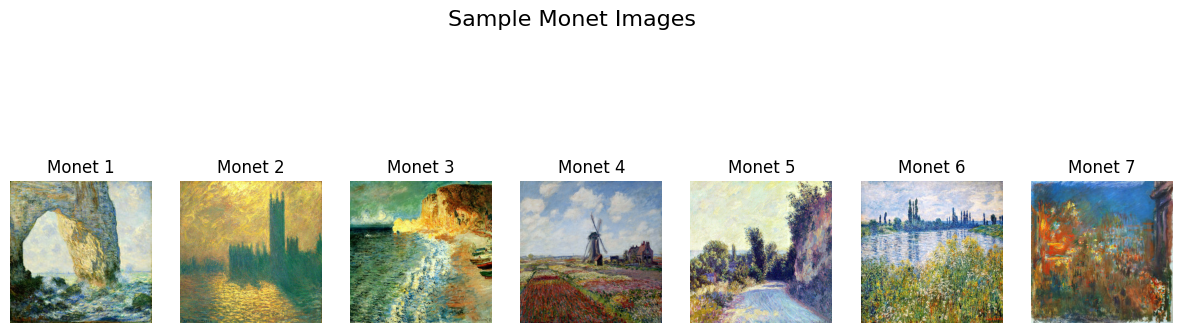

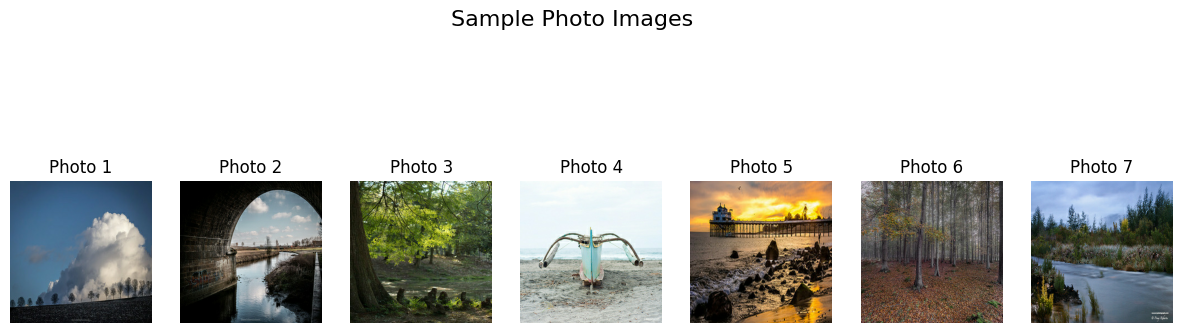

In [10]:
# defining a function to display a sample of the Monet images as well as the photo's that will be transformed
def display_samples(dataset, title, n = 5):
    plt.figure(figsize = (15, 5))
    for i, img in enumerate(dataset.take(n)):
        img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
        plt.subplot(1, n, i + 1)
        plt.imshow(img)
        plt.title(f'{title} {i + 1}')
        plt.axis('off')
    plt.suptitle(f'Sample {title} Images', fontsize = 16)
    plt.show()

display_samples(monet_ds, 'Monet', 7)
display_samples(photo_ds, 'Photo', 7)

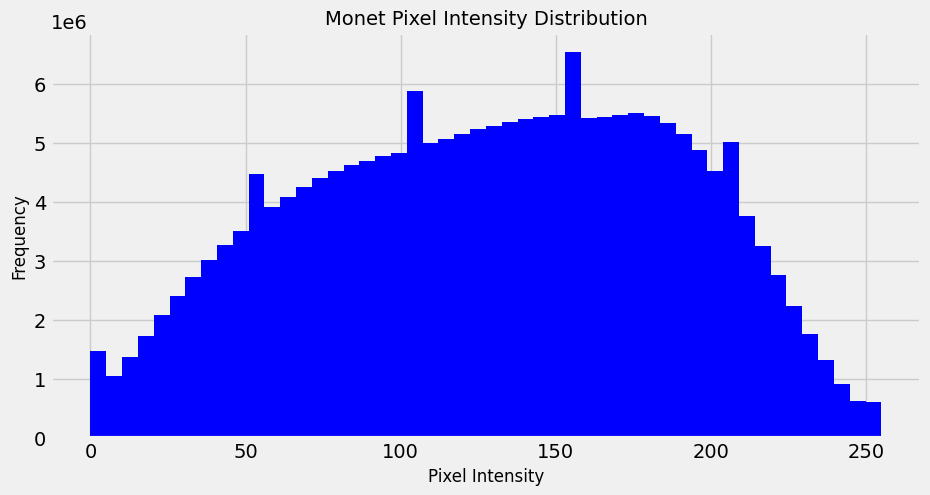

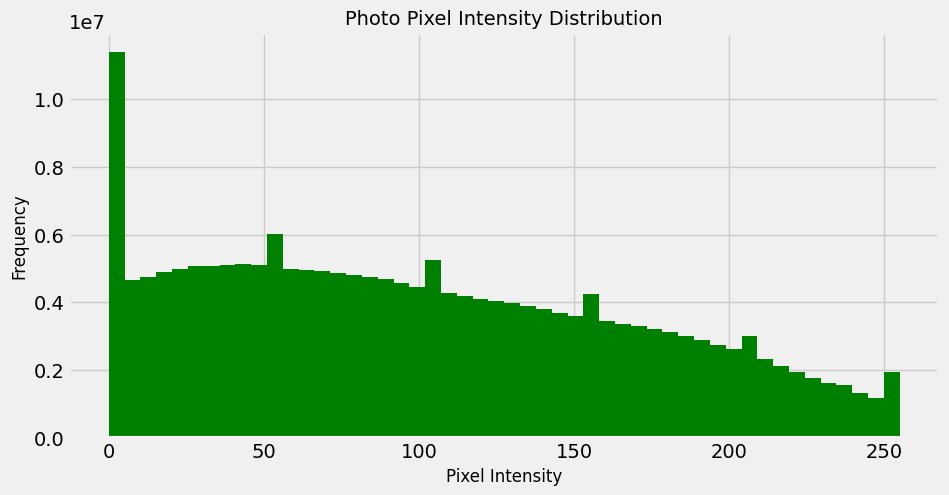

In [11]:
# plotting the pixel density for the Monet and the photos that will be transformed
plt.style.use('fivethirtyeight')
def plot_pixel_intensity_histogram(dataset, title, color):
    pixels = np.concatenate([img[0].numpy().flatten() for img in dataset.take(1000)])
    pixels = (pixels * 127.5 + 127.5).astype(np.uint8)
    plt.figure(figsize = (10, 5))
    plt.hist(pixels, bins = 50, color = color)
    plt.title(f'{title} Pixel Intensity Distribution', fontsize = 14)
    plt.xlabel('Pixel Intensity', fontsize = 12)
    plt.ylabel('Frequency', fontsize = 12)
    plt.grid(True)
    plt.show()

plot_pixel_intensity_histogram(monet_ds, 'Monet', 'blue')
plot_pixel_intensity_histogram(photo_ds, 'Photo', 'green')

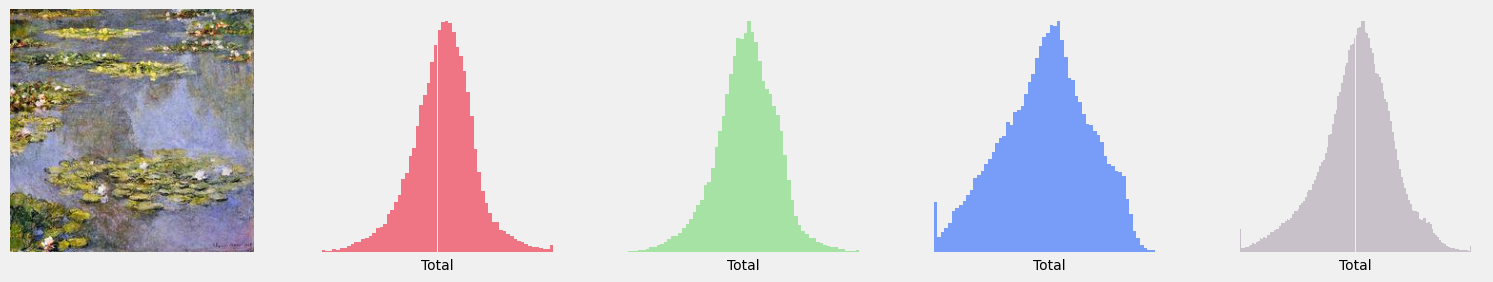

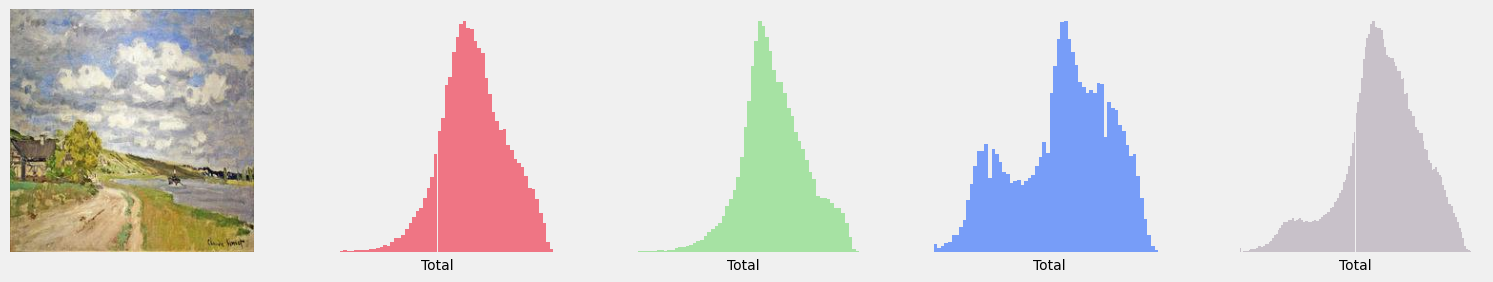

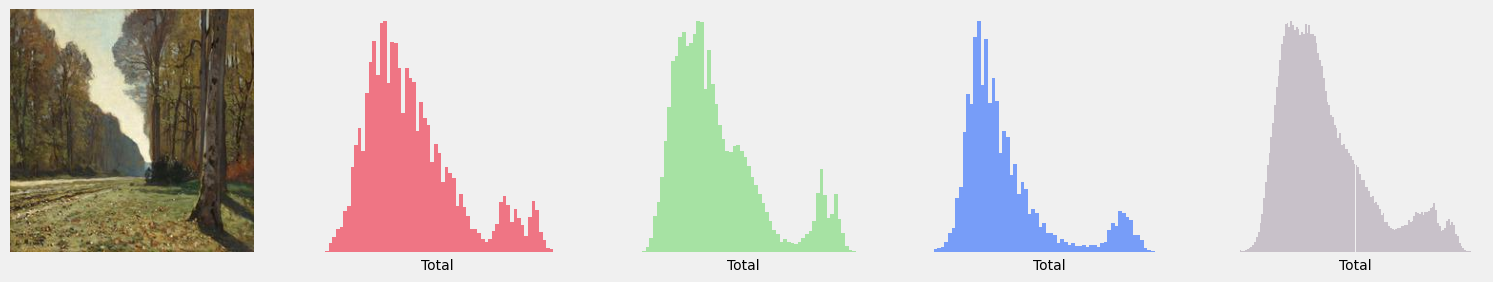

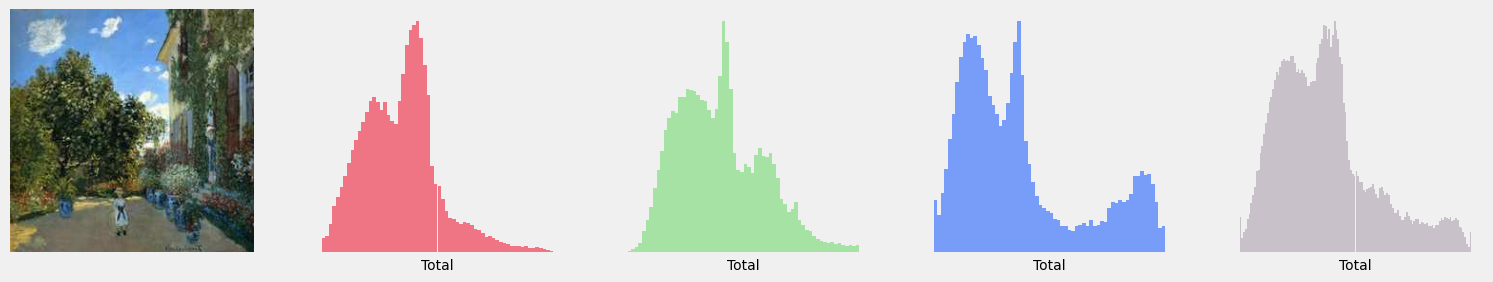

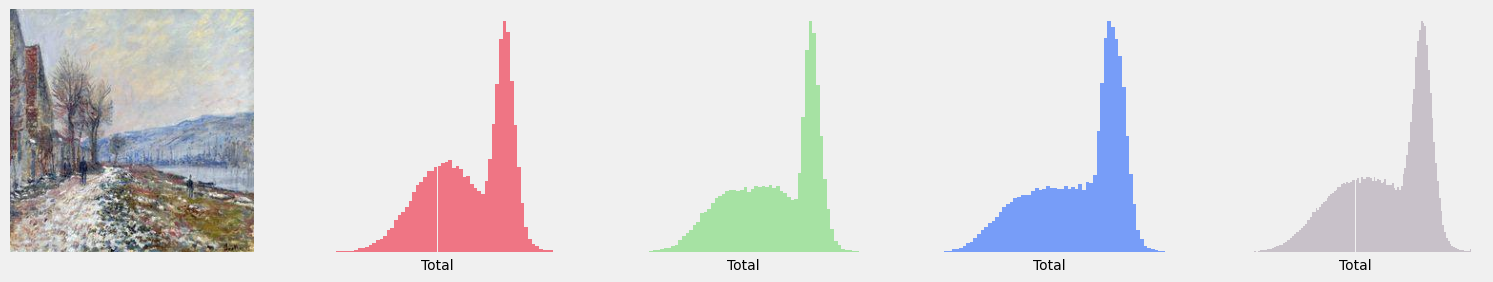

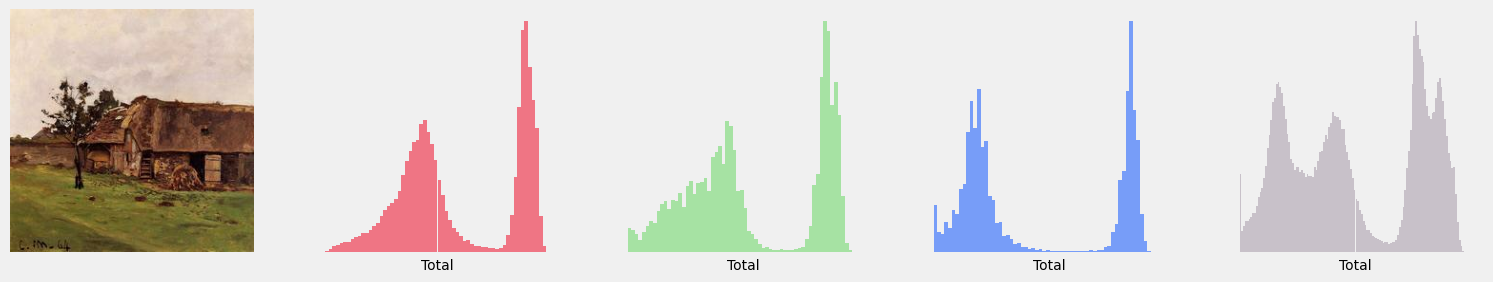

In [12]:
# creating a few different functions to plot the RGB channels for a few of the Monet and transform photos
def styling():
    for spine in plt.gca().spines.values():
        spine.set_visible(False)
        plt.xticks([])
        plt.yticks([])

def hist(image_path):
    plt.figure (figsize = (17, 3))
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    plt.subplot(1, 5, 1)
    plt.imshow(img)
    styling()
    
    custom_colors = ["#ef233c", "#76da71", "#2667ff","#aea3b0"]
    labels = ['Red Channel', 'Green Channel', 'Blue Channel', 'Total']
    
    for i in range(1, 4):
        plt.subplot(1, 5, i + 1)
        plt.hist(img[:, :, i - 1].reshape(-1), bins = 64, color = custom_colors[i - 1], alpha = 0.6)
        plt.xlabel(labels[3], fontsize = 10)
        styling()
    
    plt.subplot(1, 5, 5)
    plt.hist(img.reshape(-1), bins = 128, color = custom_colors[3], alpha = 0.6)
    plt.xlabel(labels[3], fontsize = 10)
    styling()
    plt.show()

# displaying the image using the following function
def display_hist(images_paths):
    for ind, image_path in enumerate(images_paths):
        if (ind < 6):
            hist(image_path)
            
display_hist(monet_images_path)

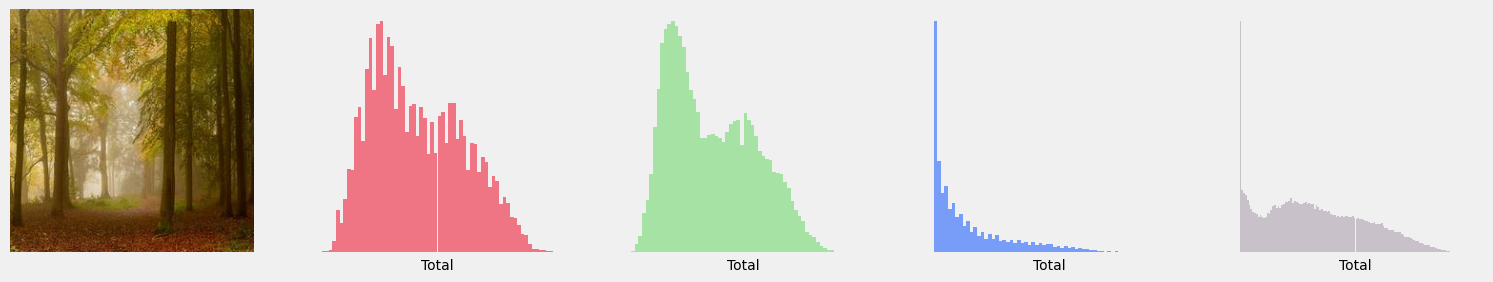

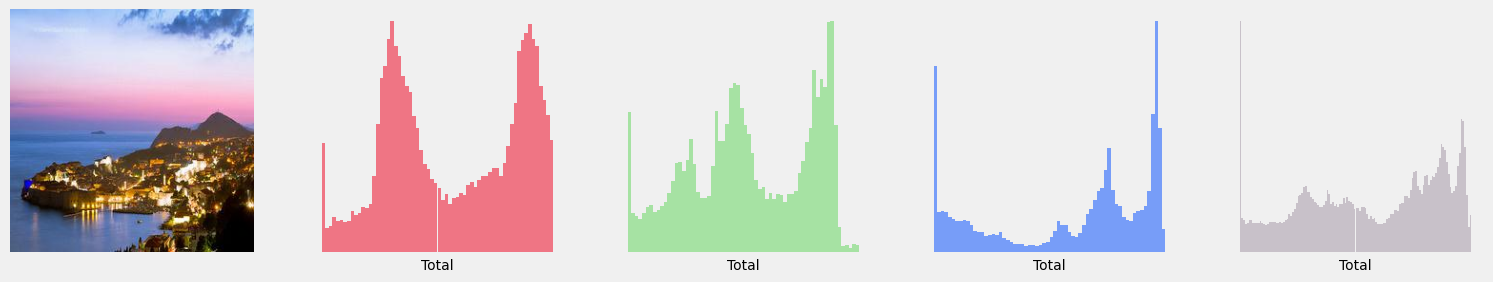

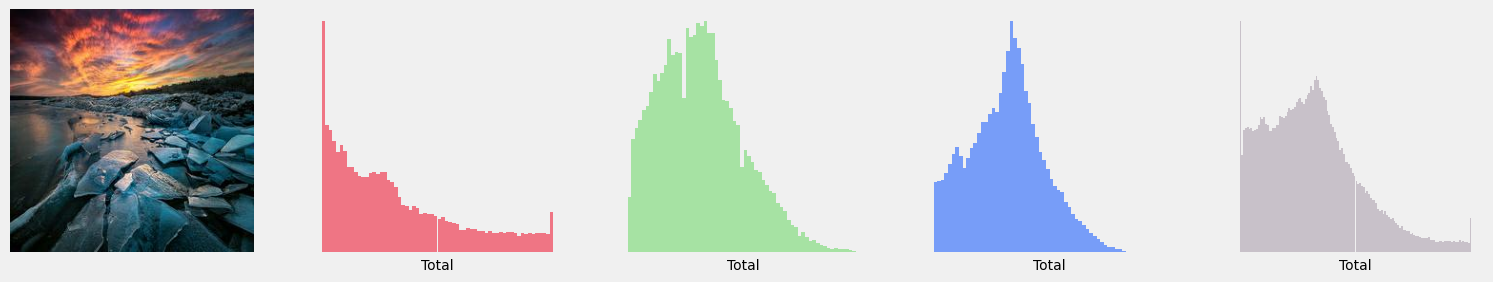

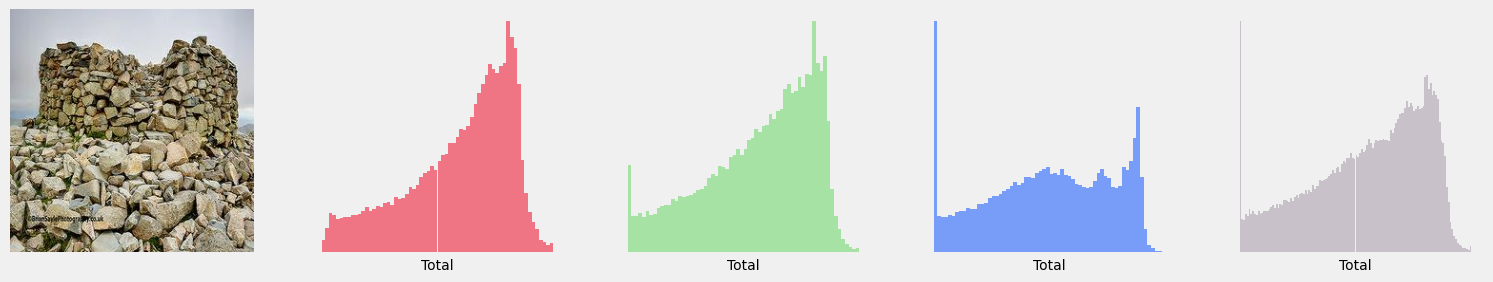

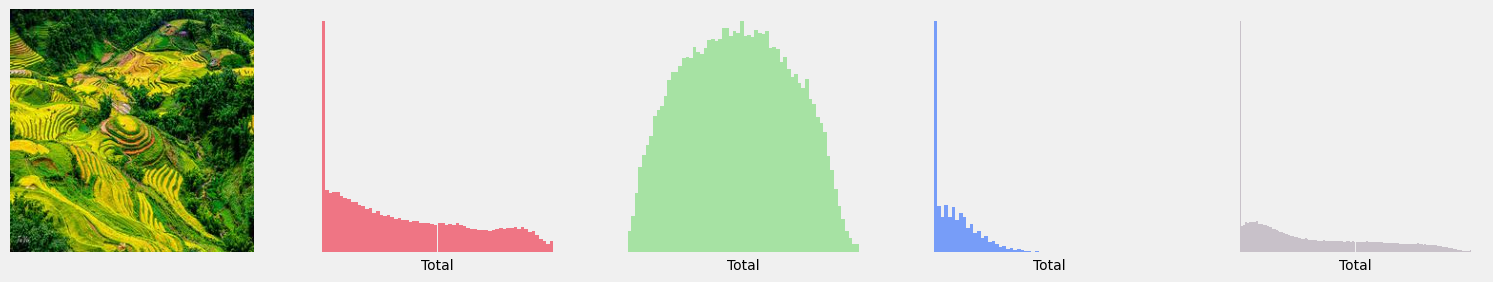

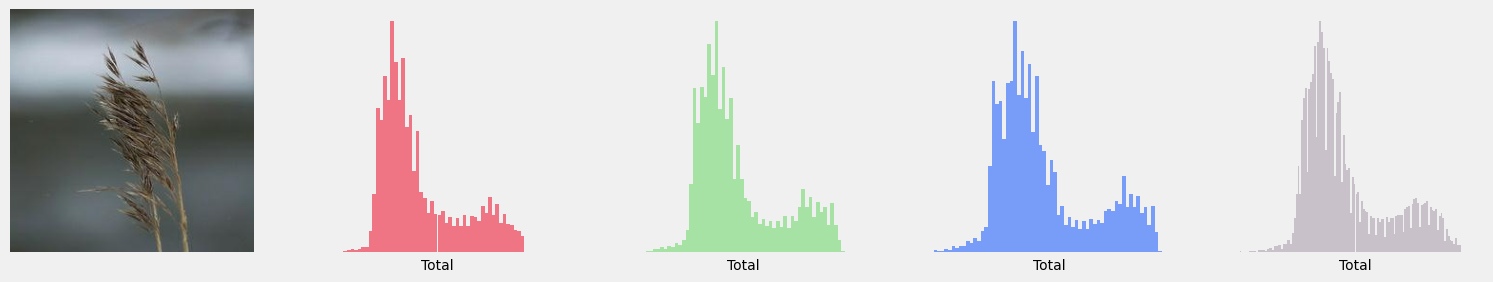

In [13]:
display_hist(photo_images_path)

In [14]:
# creating a function to showcase a few summary statistics that accompany the pixel density plot from above
def display_statistics(dataset, title):
    pixels = np.concatenate([img[0].numpy().flatten() for img in dataset.take(1000)])
    pixels = (pixels * 127.5 + 127.5).astype(np.uint8)
    mean = np.mean(pixels)
    std = np.std(pixels)
    min_pixel = np.min(pixels)
    max_pixel = np.max(pixels)
    print(f'{title} Statistics:')
    print(f'Mean: {mean:.2f}')
    print(f'Standard Deviation: {std:.2f}')
    print(f'Min: {min_pixel}')
    print(f'Max: {max_pixel}')
    print()

display_statistics(monet_ds, 'Monet')
display_statistics(photo_ds, 'Photo')

Monet Statistics:
Mean: 129.10
Standard Deviation: 59.31
Min: 0
Max: 255

Photo Statistics:
Mean: 101.77
Standard Deviation: 68.48
Min: 0
Max: 255



## Model

With the EDA procedure completed, let's start building the model. As explained in the introduction, a traditional GAN is composed of a generator and a discriminator. Both of these pieces will need to be created as well as numerous additional lines that will compile and build the different layers in correct order. This will be completed in the CycleGAN model below.

This custom CycleGAN model was designed for the specific task of creating transfer learning model that will carry out the task of understanding the Monet photos and applying the style of those picture to a new photo. I decided to use 8 layers in my generator and 4 layers in my discriminator. I had originally tried 6 layers in my generator, however, the output looked rather poor. The 2 added layers allowed the model to learn Monet's style better, and create a better output.

In the end, I set my learning rate at 2e-4, set my number of epochs to 10, and set the number of steps per epoch to 300. Setting the correct learning rate took a bit of trial and error to get an appropriate result. The number of epochs and the steps per epoch were set by trial and error, but also what the Kaggle CPU was able to train in a reasonable amount of time. The model took about 5 hours to train, yet was still able to return a positive result. 

## Generator

In [15]:
# building the generator with 8 layers of increasing size, all with the stride value set to 2 and using the 'relu'
# activation all but in the final layer
def build_generator():
    model = keras.Sequential([
        layers.Input(shape = [256, 256, 3]),
        layers.Conv2D(64, 4, strides = 2, padding = 'same', activation = 'relu', use_bias = False),
        layers.Conv2D(128, 4, strides = 2, padding = 'same', activation = 'relu', use_bias = False),
        layers.Conv2D(256, 4, strides = 2, padding = 'same', activation = 'relu', use_bias = False),
        layers.Conv2D(512, 4, strides = 2, padding = 'same', activation = 'relu', use_bias = False),
        layers.Conv2DTranspose(256, 4, strides = 2, padding = 'same', activation = 'relu', use_bias = False),
        layers.Conv2DTranspose(128, 4, strides = 2, padding = 'same', activation = 'relu', use_bias = False),
        layers.Conv2DTranspose(64, 4, strides = 2, padding = 'same', activation = 'relu', use_bias = False),
        layers.Conv2DTranspose(3, 4, strides = 2, padding = 'same', activation = 'tanh', use_bias = False)
    ])
    return model

## Discriminator

In [16]:
# building the discriminator with 4 layers of increasing size, with stride = 2 (except for the last layer),
# and using the 'relu' activation function
def build_discriminator():
    return keras.Sequential([
        layers.Input(shape = [256, 256, 3]),
        layers.Conv2D(64, 4, strides = 2, padding = 'same', activation = 'relu'),
        layers.Conv2D(128, 4, strides = 2, padding = 'same', activation = 'relu', use_bias = False),
        layers.Conv2D(256, 4, strides = 2, padding = 'same', activation = 'relu', use_bias = False),
        layers.Conv2D(1, 4, strides = 1, padding = 'valid', activation = 'relu', use_bias = False)
    ])

In [17]:
# calling out build generator and discriminator class that will be passed to the function below
monet_generator = build_generator()
photo_generator = build_generator()
monet_discriminator = build_discriminator()
photo_discriminator = build_discriminator()

## Build CycleGAN Model

With the layers defined above, now it's time to compile the model into one class. I started out by setting the specific variables and passing the optimizer and disriminator to those variables. Then defined the loss function variable.

The main 'with' loop is the forward pass that generates both fake a 'cycled' images. The Monet generator takes a real photo as the input and then generates a 'fake' Monet style image. A separate generator takes the fake Money image and attempt to reconstruct the original photo. Then, the photo generator takes a real Monet photo as input and creates a fake photo. Finally, the Monet generator takes the fake photo and attempts to reconstruct the original Monet. This process completes the work on the generator side.

On the discriminator sides, the Monet discriminator predicts whether or not the real Monet painting is real or not. The photo discriminator takes a turn at predicting whether or not the generated photo is real or fake. This process occurs twice. Then, the adversarial losses are calculated for both the Monet and photo generators and a score will be determined and passed back to the original generators.

These losses are summed and returned as the final step. This is the general framework the model is completing each training cycle.

In [18]:
# creating the CycleGan class with each of the generators and discriminators defined
class CycleGan(keras.Model):
    def __init__(self, monet_gen, photo_gen, monet_disc, photo_disc, lambda_cycle = 10):
        super(CycleGan, self).__init__()
        self.monet_gen = monet_gen
        self.photo_gen = photo_gen
        self.monet_disc = monet_disc
        self.photo_disc = photo_disc
        self.lambda_cycle = lambda_cycle
        
    def compile(self, monet_gen_optimizer, photo_gen_optimizer, monet_disc_optimizer, photo_disc_optimizer,
                gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGan, self).compile()
        self.monet_gen_optimizer = monet_gen_optimizer
        self.photo_gen_optimizer = photo_gen_optimizer
        self.monet_disc_optimizer = monet_disc_optimizer
        self.photo_disc_optimizer = photo_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent = True) as tape:
            fake_monet = self.monet_gen(real_photo, training = True)
            cycled_photo = self.photo_gen(fake_monet, training = True)
            fake_photo = self.photo_gen(real_monet, training = True)
            cycled_monet = self.monet_gen(fake_photo, training = True)
            same_monet = self.monet_gen(real_monet, training = True)
            same_photo = self.photo_gen(real_photo, training = True)

            disc_real_monet = self.monet_disc(real_monet, training = True)
            disc_real_photo = self.photo_disc(real_photo, training = True)
            disc_fake_monet = self.monet_disc(fake_monet, training = True)
            disc_fake_photo = self.photo_disc(fake_photo, training = True)

            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)
            cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)
            total_monet_gen_loss = monet_gen_loss + cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        monet_gen_grads = tape.gradient(total_monet_gen_loss, self.monet_gen.trainable_variables)
        photo_gen_grads = tape.gradient(total_photo_gen_loss, self.photo_gen.trainable_variables)
        monet_disc_grads = tape.gradient(monet_disc_loss, self.monet_disc.trainable_variables)
        photo_disc_grads = tape.gradient(photo_disc_loss, self.photo_disc.trainable_variables)

        self.monet_gen_optimizer.apply_gradients(zip(monet_gen_grads, self.monet_gen.trainable_variables))
        self.photo_gen_optimizer.apply_gradients(zip(photo_gen_grads, self.photo_gen.trainable_variables))
        self.monet_disc_optimizer.apply_gradients(zip(monet_disc_grads, self.monet_disc.trainable_variables))
        self.photo_disc_optimizer.apply_gradients(zip(photo_disc_grads, self.photo_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

## Compile and Train Model

With the model built, now the training cam begin. I set the learning rate to be 2e-4 and compiled both the generators and optimizers using the compile function. Finally, the number of epochs and steps is defined, in this case 10, and 300 respectively model is fit to both datasets and the training can begin.

In [19]:
monet_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
photo_gen_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
monet_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)
photo_disc_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1 = 0.5)

cycle_gan = CycleGan(monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=10)
cycle_gan.compile(
        monet_gen_optimizer = monet_gen_optimizer,
        photo_gen_optimizer = photo_gen_optimizer,
        monet_disc_optimizer = monet_disc_optimizer,
        photo_disc_optimizer = photo_disc_optimizer,
        gen_loss_fn = lambda x: tf.keras.losses.BinaryCrossentropy(from_logits = True)(tf.ones_like(x), x),
        disc_loss_fn = lambda real, fake: (tf.keras.losses.BinaryCrossentropy(from_logits = True)(tf.ones_like(real), real) + tf.keras.losses.BinaryCrossentropy(from_logits = True)(tf.zeros_like(fake), fake)) * 0.5,
        cycle_loss_fn = lambda real, cycled, lambda_cycle: lambda_cycle * tf.reduce_mean(tf.abs(real - cycled)),
        identity_loss_fn = lambda real, same, lambda_cycle: lambda_cycle * 0.5 * tf.reduce_mean(tf.abs(real - same))
    )

cycle_gan.fit(tf.data.Dataset.zip((monet_ds, photo_ds)), epochs = 10, steps_per_epoch = 350)

Epoch 1/10
  3/350 ━━━━━━━━━━━━━━━━━━━━ 19s 56ms/step - monet_disc_loss: 0.6527 - monet_gen_loss: 11.5357 - photo_disc_loss: 0.6420 - photo_gen_loss: 12.2617

I0000 00:00:1738714645.036500      66 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


350/350 ━━━━━━━━━━━━━━━━━━━━ 31s 50ms/step - monet_disc_loss: 0.5374 - monet_gen_loss: 6.9584 - photo_disc_loss: 0.5207 - photo_gen_loss: 7.1066
Epoch 2/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - monet_disc_loss: 0.5273 - monet_gen_loss: 5.8743 - photo_disc_loss: 0.5507 - photo_gen_loss: 5.9313
Epoch 3/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - monet_disc_loss: 0.5498 - monet_gen_loss: 5.2416 - photo_disc_loss: 0.5815 - photo_gen_loss: 5.2234
Epoch 4/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - monet_disc_loss: 0.5304 - monet_gen_loss: 4.9120 - photo_disc_loss: 0.5552 - photo_gen_loss: 4.9166
Epoch 5/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - monet_disc_loss: 0.5237 - monet_gen_loss: 4.6738 - photo_disc_loss: 0.5519 - photo_gen_loss: 4.6964
Epoch 6/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 49ms/step - monet_disc_loss: 0.6291 - monet_gen_loss: 4.5060 - photo_disc_loss: 0.5719 - photo_gen_loss: 4.5207
Epoch 7/10
350/350 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - monet_disc_loss: 0.

## Visualize Results

With our model fit, let's visualize our results. The grand reveal! After tweaking the model a few times, the converted photos were generated successfully. There is still some blurriness present, however, the transferred style can still be seen. This is a 

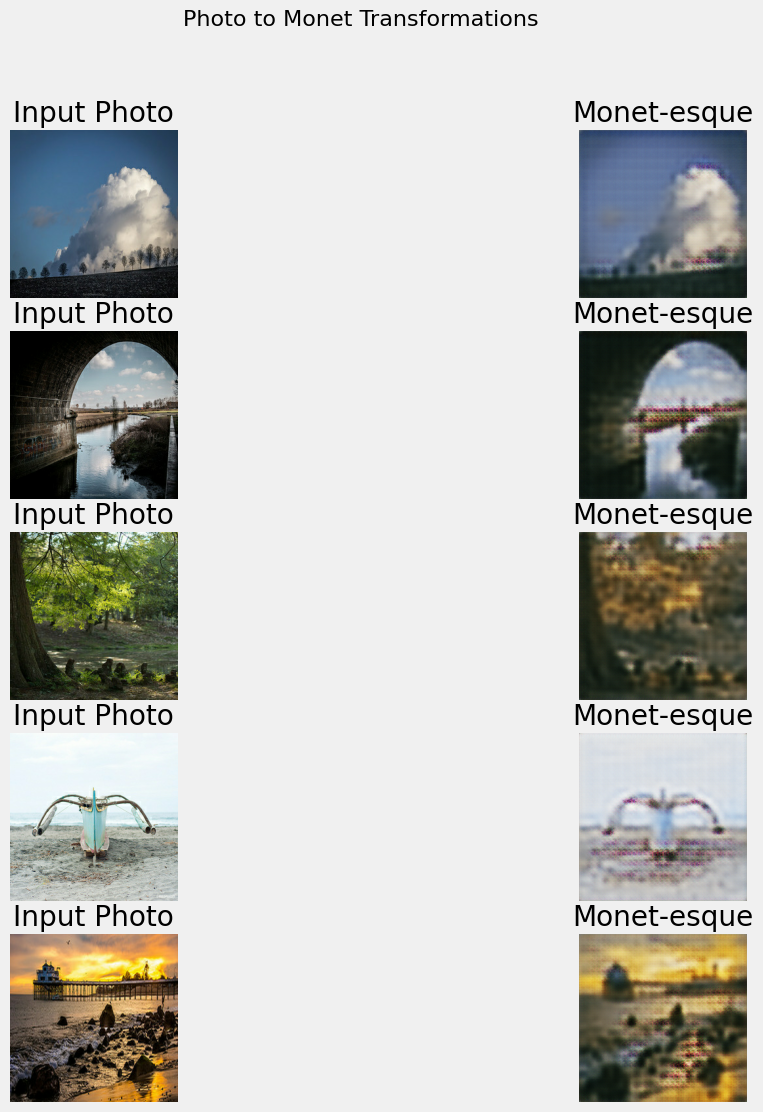

In [20]:
_, ax = plt.subplots(5, 2, figsize = (12, 12))
for i, img in enumerate(photo_ds.take(5)):
    prediction = monet_generator(img, training = False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)
    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.suptitle('Photo to Monet Transformations', fontsize = 16)
plt.show()

## Submission File Creation

In [21]:
# Ensure the directory exists
output_dir = "../images"
os.makedirs(output_dir, exist_ok=True)

# Generate and save predictions
i = 1
for img in photo_ds.take(1000):  # Limit the number of images to avoid running out of memory
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save(os.path.join(output_dir, f"{i}.jpg"))
    i += 1

# Create a zip file of the saved images
shutil.make_archive("/kaggle/working/images", 'zip', output_dir)

'/kaggle/working/images.zip'

## Conclusion

Throughout this project, we were successful in implementing a CycleGAN model to transform photos into Monet-style paintings. We started by importing the proper packages, then was able to load the .pdf images (which I had no prior experience with), minor data cleaning, some EDA that was helpful to understand the images we were working with, building the model and discriminator, then finally training and submitting the results.

## Results

The CycleGAN model was able to generate Monet-style paintings, although not incredibly well. I had seen other submission notebooks and seen the amazing photos they were able to generate. The photos my CycleGAN created was good, however, I had hoped for more. 

## Challenges

I found this project extremely challenging due to the complexity of building and training the model. I also think the nature of the .pdf image dataset made things more difficult than a more simplified classification data science project.

## Future Work

Enhancing the model to incorporate more sophisticated features and layers would certainly improve the output images. Although I did some model tuning, tuning very specific hyperparameters would also increase the models performance.